## 1) 어텐션을 이용한 텍스트 요약 Text Summarization with Attention mechanism
* 텍스트 요약: 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 작은 요약문으로 변환
* 읽는 사람이 시간을 단축해서 내용을 빠르게 이해할 수 있다는 점에서 꼭 필요한 능력
* 그 중 한 가지 방법인 seq2seq 구현
* 그리고 어텐션 메커니즘 적용

### 1. 텍스트 요약 Text Summarization
#### 1) 추출적 요약(Extractive summarization)
* 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법
* 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들
* 대표적인 알고리즘으로 머신러닝 알고리즘인 TextRank
* 단점: 이미 존재하는 문장이나 단어구로만 구성하므로 모델의 언어 표현 능력이 제한됨
#### 2) 추상적 요약(Abstractive summarization)
* 원문에 없던 문장도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법
* 주로 인공 신경망 사용. 대표적 모델로 seq2seq 있음.
* 단점: seq2seq와 같은 인공 신경망들은 기본적으로 지도 학습. 그러므로 데이터를 구성하는 것 자체가 하나의 부담


### 2. 아마존 리뷰 데이터에 대한 이해


In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

In [5]:
from google.colab import drive
drive.mount('content/')


Mounted at content/


In [13]:
import csv

#### 1) 데이터 로드

In [26]:
data = pd.read_csv('/content/Reviews.csv', nrows=100000, engine='python', encoding='utf-8', error_bad_lines=False, quoting=csv.QUOTE_NONE)
print('전체 리뷰 개수 :',(len(data)))

Streaming output truncated to the last 5000 lines.
Skipping line 7578: Expected 10 fields in line 7578, saw 12
Skipping line 7579: Expected 10 fields in line 7579, saw 19
Skipping line 7580: Expected 10 fields in line 7580, saw 12
Skipping line 7581: Expected 10 fields in line 7581, saw 11
Skipping line 7582: Expected 10 fields in line 7582, saw 24
Skipping line 7583: Expected 10 fields in line 7583, saw 14
Skipping line 7585: Expected 10 fields in line 7585, saw 14
Skipping line 7588: Expected 10 fields in line 7588, saw 11
Skipping line 7589: Expected 10 fields in line 7589, saw 11
Skipping line 7591: Expected 10 fields in line 7591, saw 15
Skipping line 7593: Expected 10 fields in line 7593, saw 16
Skipping line 7596: Expected 10 fields in line 7596, saw 12
Skipping line 7597: Expected 10 fields in line 7597, saw 13
Skipping line 7598: Expected 10 fields in line 7598, saw 14
Skipping line 7600: Expected 10 fields in line 7600, saw 12
Skipping line 7601: Expected 10 fields in line 76

전체 리뷰 개수 : 4175


Skipping line 14390: Expected 10 fields in line 14390, saw 12
Skipping line 14391: Expected 10 fields in line 14391, saw 12
Skipping line 14392: Expected 10 fields in line 14392, saw 11
Skipping line 14393: Expected 10 fields in line 14393, saw 12
Skipping line 14395: Expected 10 fields in line 14395, saw 12
Skipping line 14397: Expected 10 fields in line 14397, saw 11
Skipping line 14400: Expected 10 fields in line 14400, saw 11
Skipping line 14402: Expected 10 fields in line 14402, saw 11
Skipping line 14403: Expected 10 fields in line 14403, saw 11
Skipping line 14404: Expected 10 fields in line 14404, saw 21
Skipping line 14405: Expected 10 fields in line 14405, saw 11
Skipping line 14407: Expected 10 fields in line 14407, saw 11
Skipping line 14408: Expected 10 fields in line 14408, saw 12
Skipping line 14410: Expected 10 fields in line 14410, saw 14
Skipping line 14412: Expected 10 fields in line 14412, saw 15
Skipping line 14413: Expected 10 fields in line 14413, saw 11
Skipping

In [17]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"""Product arrived labeled as Jumbo Salted Peanu..."
2,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
3,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
4,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [56]:
# 필요한 열만 저장
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,looking secret ingredient robitussin believe f...,cough medicine
3,right mostly sprouting cats eat grass love rot...,yay barley
4,healthy dog food good digestion also good smal...,healthy dog food


In [57]:
data.sample(10)

,Text,Summary
2130,received package hamburger mix one dearest fri...,yummy
911,grandson loves makes cup everytime stops quick...,cup cocoa
636,husband loves pudding kind dessert end dinner ...,good for cravings
1700,daily grocery shopping amazon like awwww yeah ...,mm mm yummy
2827,amazing low carber cannot believe available,amazing
3202,delicious pepperoni buying oberto since wish c...,nothing better
541,bought gift mother likes says hard open unwrap...,little hard to open
388,love stevia tried many different kinds years o...,great product
1074,eating panda licorice number years hard someon...,all natural licorice cannot be beat
25,tea flavor whole brunch artifial flavors retur...,no tea flavor


In [58]:
len(data)

3983

### 2) 데이터 정제하기

In [59]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 3983
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 3148


In [60]:
# text열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=["Text"], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 3983


In [61]:
# null 샘플 있는지 확인
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


In [62]:
# null 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 3983


In [63]:
# 샘플 내부 전처리
# 단어 정규화와 불용어 제거를 위해서 사전 사용

# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [64]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
# NLTK의 불용어 저장하고 개수 확인
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'that', 'wasn', 'only', 'into', 'yours', 'are', "shan't", 'the', 'him', 'both', 'before', 'were', 'has', "mightn't", "aren't", 'yourselves', 'and', 'these', "you'd", 'once', 'too', 'we', 'himself', 'doing', 'd', 'an', "you've", 'having', 'if', 'more', 'mightn', 'y', 'whom', "shouldn't", 'itself', "that'll", 'not', 'from', 'aren', 'for', 'up', "isn't", 'he', 'through', 'after', 'very', 'own', 'any', 'here', 'while', 'nor', "didn't", 'weren', 'o', 'myself', 'does', 'hadn', 'all', 'as', "you're", 'those', 'against', 'can', 'had', 'ain', 'you', 'such', "weren't", 'won', 'same', "should've", 'which', 'it', 'm', "you'll", 't', 'below', 'down', 'doesn', "she's", 'herself', 'them', 'was', 'at', 'being', 'by', 'of', 'am', "doesn't", 'hers', 'now', 'shan', 'ma', 'mustn', 'with', 'again', 'theirs', 'she', 'is', 'they', 'on', 'no', 'our', 'me', 'shouldn', 'themselves', 'each', 'will', 'haven', 'why', 'where', 'how', 'my', 'what', 'do', 'or', 'so', 're', "couldn't", 'other', 'above', 

In [66]:
# 전처리 함수 설계
def preprocess_sentence(sentence, remove_stopwords = True):
  sentence = sentence.lower() #텍스트 소문자화
  sentence = BeautifulSoup(sentence, "lxml").text # html 태그 제거
  sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 제거
  sentence = re.sub('"', '', sentence) #쌍따옴표 " 제거
  sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
  sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
  sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
  sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

  # 불용어 제거 (Text)
  if remove_stopwords:
      tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
  # 불용어 미제거 (Summary)
  else:
      tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
  return tokens

In [67]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [68]:
# Text열 전처리
# 전처리 후에는 5개의 전처리 된 샘플 출력
clean_text = []
for s in data['Text']:
  clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'right mostly sprouting cats eat grass love rotate around wheatgrass rye',
 'healthy dog food good digestion also good small puppies dog eats required amount every feeding']

In [69]:
# Summary 열 전처리
clean_summary=[]
for s in data['Summary']:
  clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'cough medicine',
 'yay barley',
 'healthy dog food']

In [70]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [71]:
# 전처리 과정에서 빈 값 생겼나?
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text       0
Summary    0
dtype: int64


In [72]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 3983


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 216
텍스트의 평균 길이 : 19.88224956063269
요약의 최소 길이 : 1
요약의 최대 길이 : 25
요약의 평균 길이 : 3.3276424805423046


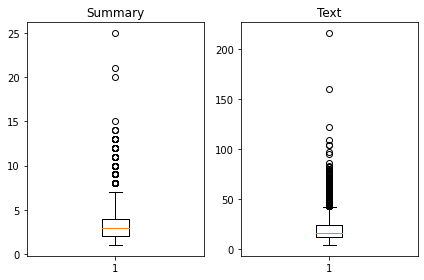

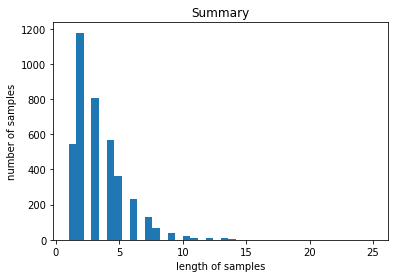

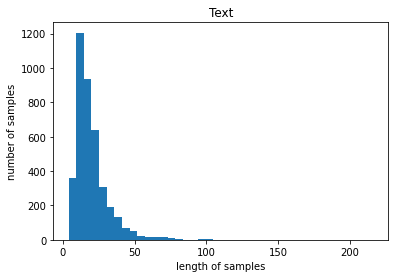

In [73]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [74]:
text_max_len = 50
summary_max_len = 8

In [75]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [76]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9738890283705749


In [77]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9766507657544564


In [78]:
# 최대 길이보다 큰 샘플들 제거
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 3797


In [79]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,looking secret ingredient robitussin believe f...,cough medicine
3,right mostly sprouting cats eat grass love rot...,yay barley
4,healthy dog food good digestion also good smal...,healthy dog food
